In [375]:
import joblib
import re
import pandas as pd
import matplotlib.pyplot as plt
import obonet
import seaborn as sb
from Bio import SeqIO

%matplotlib inline

In [3]:
! ls ..

README.md      notebooks      setup.py
data           pyproject.toml src


# Load in Data

### Load in Train Terminology data

In [4]:
#load in train terminology data
train_terms = pd.read_csv('../data/cafa-5-protein-function-prediction/Train/train_terms.tsv',sep="\t")

In [5]:
train_terms.head()

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


### Load in Train Taxonomy data

In [6]:
#load in train taxonomy data
train_tax = pd.read_csv('../data/cafa-5-protein-function-prediction/Train/train_taxonomy.tsv',sep="\t")

In [7]:
train_tax.head()

,EntryID,taxonomyID
0,Q8IXT2,9606
1,Q04418,559292
2,A8DYA3,7227
3,Q9UUI3,284812
4,Q57ZS4,185431


### Load in Train Sequences data

In [8]:
#load in train_sequences data
protein_sequences = '../data/cafa-5-protein-function-prediction/Train/train_sequences.fasta'
sequences = SeqIO.parse(protein_sequences, "fasta")

In [9]:
#read in fasta data protein by protein
## create list of protein ids, descriptions & sequences
protein_ids=[]
protein_descriptions=[]
protein_sequences=[]
for seq in sequences:
    protein_ids.append(seq.id)
    protein_descriptions.append(seq.description)
    protein_sequences.append(seq.seq)

In [10]:
# assemble dataframe for train sequences
d = {'EntryID': protein_ids, 'description': protein_descriptions, 'sequence': protein_sequences}
train_sequences = pd.DataFrame(data=d)

In [11]:
train_sequences.head()

,EntryID,description,sequence
0,P20536,P20536 sp|P20536|UNG_VACCC Uracil-DNA glycosyl...,"(M, N, S, V, T, V, S, H, A, P, Y, T, I, T, Y, ..."
1,O73864,O73864 sp|O73864|WNT11_DANRE Protein Wnt-11 OS...,"(M, T, E, Y, R, N, F, L, L, L, F, I, T, S, L, ..."
2,O95231,O95231 sp|O95231|VENTX_HUMAN Homeobox protein ...,"(M, R, L, S, S, S, P, P, R, G, P, Q, Q, L, S, ..."
3,A0A0B4J1F4,A0A0B4J1F4 sp|A0A0B4J1F4|ARRD4_MOUSE Arrestin ...,"(M, G, G, E, A, G, A, D, G, P, R, G, R, V, K, ..."
4,P54366,P54366 sp|P54366|GSC_DROME Homeobox protein go...,"(M, V, E, T, N, S, P, P, A, G, Y, T, L, K, R, ..."


### Load in Gene Ontology data

In [28]:
graph = obonet.read_obo('../data/cafa-5-protein-function-prediction/Train/go-basic.obo')

In [30]:
# get unique go_terms from train_terms
unique_GO_terms = list(train_terms.term.unique());

In [112]:
# create function to extract relationship information from graph
def extract_rel(term_list, graph, rel="is_a"):
    extraction_regex = {
    "part_of": ("part_of GO:\d{7}", "GO:\d{7}"),
    "is_a": {"is_a": "is_a"},
    "regulates": ("regulates GO:\d{7}", "GO:\d{7}")
    }
    terms =[]
    rel_list = []
    for term in term_list:
        if rel == "is_a":
            rel_list.append(graph.nodes[term][rel]) if rel in graph.nodes[term] else rel_list.append(None)
        elif rel == "part_of" or rel == "regulates":
            mapper = extraction_regex[rel]
            full_finder = re.compile(mapper[0])
            term_finder = re.compile(mapper[1])
            if "relationship" in graph.nodes[term]:
                rel_list.append(set([term_finder.search(x)[0] if full_finder.search(x) else None for x in graph.nodes[term]["relationship"]]))
            else:
                rel_list.append("N/A")  
            #extracted = [term_finder.search(x) if full_finder.search(x) else None for x in graph.nodes[term]["relationship"]]
            #rel_list.append(extracted)
    return rel_list

In [113]:
#extract part_of, regulates, & is_a relationships for each unique_GO_term
a = extract_rel(unique_GO_terms, graph, rel='part_of')
b = extract_rel(unique_GO_terms, graph, rel='regulates')
c = extract_rel(unique_GO_terms, graph, rel='is_a')

In [139]:
# create df for go_term, is_a, part_of & regulates
d = {'term': unique_GO_terms, 'is_a': c, 'part_of': a, 'regulates': b}
go_connections = pd.DataFrame(d)
go_connections.sort_values(by='term', inplace=True)

# Feature Engineering & Merging Dataframes

#### Pull subontologies for each GO-term & append to go_connections 

In [311]:
#pull subontologies for each unique GO from train_terms
subontologies = train_terms[['term','aspect']].groupby('term').aspect.unique().apply(lambda x: ''.join(x))
subontologies = pd.DataFrame(subontologies).reset_index()

In [143]:
#add subontologies to go_connections by joining on terms
go_connections = go_connections.join(subontologies.set_index('term'), on='term', how='left')

#### Get count columns for each relationship type: is_a, part_of, and regulates

In [380]:
def len_of_list(x):
    """Take in list/series entry & return len of the list/series.
    Nonetypes should be marked as length 0."""
    if x!={None} and x!="N/A" and x is not None:
        return len(x)
    else:
        return 0

In [389]:
#add count columns for is_a, part_of, and regulates entries
go_connections['is_a_count'] = go_connections['is_a'].apply(len_of_list)
go_connections['part_of_count'] = go_connections['part_of'].apply(len_of_list)
go_connections['regulates_count'] = go_connections['regulates'].apply(len_of_list)

In [392]:
go_connections.head()

,term,is_a,part_of,regulates,aspect,is_a_count,part_of_count,regulates_count
16843,GO:0000001,"[GO:0048308, GO:0048311]",N/A,N/A,BPO,2,0,0
5764,GO:0000002,[GO:0007005],N/A,N/A,BPO,1,0,0
512,GO:0000003,[GO:0008150],N/A,N/A,BPO,1,0,0
28165,GO:0000006,[GO:0005385],N/A,N/A,MFO,1,0,0
30392,GO:0000007,[GO:0005385],N/A,N/A,MFO,1,0,0


#### Merge train_sequences & train_tax into one dataframe

In [147]:
# join train_tax to train_sequences by EntryID
train_proteins = train_sequences.join(train_tax.set_index('EntryID'), on='EntryID', how='left')

### Extract data and add to train_proteins dataframe:
- sequence length
- GO counts for each protein (from train_terms)
- unique # of amino acids in the protein sequence

In [149]:
#for each protein, get len of sequence id & number of associated GOs
train_proteins['sequence_length'] = train_proteins.sequence.apply(lambda x: len(x))

In [150]:
# GO counts for each protein from train_terms
GO_counts_by_protein = pd.DataFrame(train_terms.EntryID.value_counts().reindex()).reset_index()
# join counts column to train_proteins
train_proteins = train_proteins.join(GO_counts_by_protein.set_index('EntryID'), on='EntryID', how='left')
#rename count column to say term_count (for GO "terms")
train_proteins.rename(columns={'count': 'term_count'}, inplace=True);

In [152]:
#get unique # of amino acids in the protein sequence
train_proteins['amino_count'] = train_proteins.sequence.apply(lambda x: len(set(x)))

In [155]:
train_proteins.head()

,EntryID,description,sequence,taxonomyID,sequence_length,term_count,amino_count
0,P20536,P20536 sp|P20536|UNG_VACCC Uracil-DNA glycosyl...,"(M, N, S, V, T, V, S, H, A, P, Y, T, I, T, Y, ...",10249,218,33,20
1,O73864,O73864 sp|O73864|WNT11_DANRE Protein Wnt-11 OS...,"(M, T, E, Y, R, N, F, L, L, L, F, I, T, S, L, ...",7955,354,170,20
2,O95231,O95231 sp|O95231|VENTX_HUMAN Homeobox protein ...,"(M, R, L, S, S, S, P, P, R, G, P, Q, Q, L, S, ...",9606,258,62,20
3,A0A0B4J1F4,A0A0B4J1F4 sp|A0A0B4J1F4|ARRD4_MOUSE Arrestin ...,"(M, G, G, E, A, G, A, D, G, P, R, G, R, V, K, ...",10090,415,45,20
4,P54366,P54366 sp|P54366|GSC_DROME Homeobox protein go...,"(M, V, E, T, N, S, P, P, A, G, Y, T, L, K, R, ...",7227,415,20,20


For each EntryID in train_terms: get proportion of BPO, CCO & MPOs.

Convert to dataframe & join to train_proteins dataframe.

In [190]:
# Group train terms by EntryID
# get distribution of aspect proportions for each Entry ID
groups = train_terms.groupby("EntryID")
aspect_dist = groups.aspect.value_counts(normalize=True)

In [287]:
# convert aspect_dist into dataframe
aspect_dist = aspect_dist.reset_index()
aspect_dist = aspect_dist.set_index(['EntryID', 'aspect']).proportion.unstack(fill_value = 0).reset_index()

In [305]:
# add suffix: _prop to BPO, CCO, and MFO
cols = ['BPO', 'CCO', 'MFO']
aspect_dist = aspect_dist.rename(columns={c: c+'_prop' for c in aspect_dist.columns if c in cols})

In [307]:
# join aspect_dist to train_proteins by EntryID
train_proteins = train_proteins.join(aspect_dist.set_index('EntryID'), on='EntryID', how='left')

In [308]:
train_proteins

,EntryID,description,sequence,taxonomyID,sequence_length,term_count,amino_count,BPO_prop,CCO_prop,MFO_prop
0,P20536,P20536 sp|P20536|UNG_VACCC Uracil-DNA glycosyl...,"(M, N, S, V, T, V, S, H, A, P, Y, T, I, T, Y, ...",10249,218,33,20,0.909091,0.000000,0.090909
1,O73864,O73864 sp|O73864|WNT11_DANRE Protein Wnt-11 OS...,"(M, T, E, Y, R, N, F, L, L, L, F, I, T, S, L, ...",7955,354,170,20,0.941176,0.029412,0.029412
2,O95231,O95231 sp|O95231|VENTX_HUMAN Homeobox protein ...,"(M, R, L, S, S, S, P, P, R, G, P, Q, Q, L, S, ...",9606,258,62,20,0.548387,0.209677,0.241935
3,A0A0B4J1F4,A0A0B4J1F4 sp|A0A0B4J1F4|ARRD4_MOUSE Arrestin ...,"(M, G, G, E, A, G, A, D, G, P, R, G, R, V, K, ...",10090,415,45,20,0.622222,0.266667,0.111111
4,P54366,P54366 sp|P54366|GSC_DROME Homeobox protein go...,"(M, V, E, T, N, S, P, P, A, G, Y, T, L, K, R, ...",7227,415,20,20,0.000000,0.400000,0.600000
...,...,...,...,...,...,...,...,...,...,...
142241,A0A286YAI0,A0A286YAI0 tr|A0A286YAI0|A0A286YAI0_DANRE Macr...,"(M, E, T, E, V, D, D, F, P, G, K, A, S, I, F, ...",7955,450,17,20,1.000000,0.000000,0.000000
142242,A0A1D5NUC4,A0A1D5NUC4 tr|A0A1D5NUC4|A0A1D5NUC4_CHICK Mito...,"(M, S, A, A, A, S, A, E, M, I, E, T, P, P, V, ...",9031,643,26,20,1.000000,0.000000,0.000000
142243,Q5RGB0,Q5RGB0 tr|Q5RGB0|Q5RGB0_DANRE Potassium channe...,"(M, A, D, K, G, P, I, L, T, S, V, I, I, F, Y, ...",7955,448,35,20,0.371429,0.000000,0.628571
142244,A0A2R8QMZ5,A0A2R8QMZ5 tr|A0A2R8QMZ5|A0A2R8QMZ5_DANRE Myoc...,"(M, G, R, K, K, I, Q, I, T, R, I, M, D, E, R, ...",7955,459,91,20,0.879121,0.000000,0.120879


# Summary of Dataframes
##### train_proteins

Contains: protein ID, protein description, protein sequence, taxonomy ID, protein sequence length, go term counts per protein, & counts of unique amino acids, & aspect proportions (BPO, CCO, and MFO)


##### go_connections

Contains: go terms, is_a relationships, part_of relationships, regulates relationships, aspect, is_a count, part_of count, & regulates count


##### train_terms

Contains: protein ID, go term, and aspect

# Export Dataframes

In [402]:
import joblib

joblib.dump(train_proteins, '../data/cafa-5-protein-function-prediction/Wrangled/train_proteins.pkl')
joblib.dump(go_connections, '../data/cafa-5-protein-function-prediction/Wrangled/go_connections.pkl')
joblib.dump(train_terms, '../data/cafa-5-protein-function-prediction/Wrangled/train_terms.pkl')

['../data/cafa-5-protein-function-prediction/Wrangled/train_proteins.pkl']

## Visualizing Data

In [407]:
!ls ..

README.md      notebooks      setup.py
data           pyproject.toml src


In [408]:
new_go = joblib.load('../data/flow_output/processed_go.pkl')
new_proteins = joblib.load('../data/flow_output/protein.pkl')

In [410]:
new_go.equals(go_connections)

True

In [411]:
new_proteins.equals(train_proteins)

True

In [217]:
#
x = list(range(1, 31466, 110))
y = [train_terms.term.value_counts(normalize=True)[:x].sum() for x in range(1, 31466, 110)]

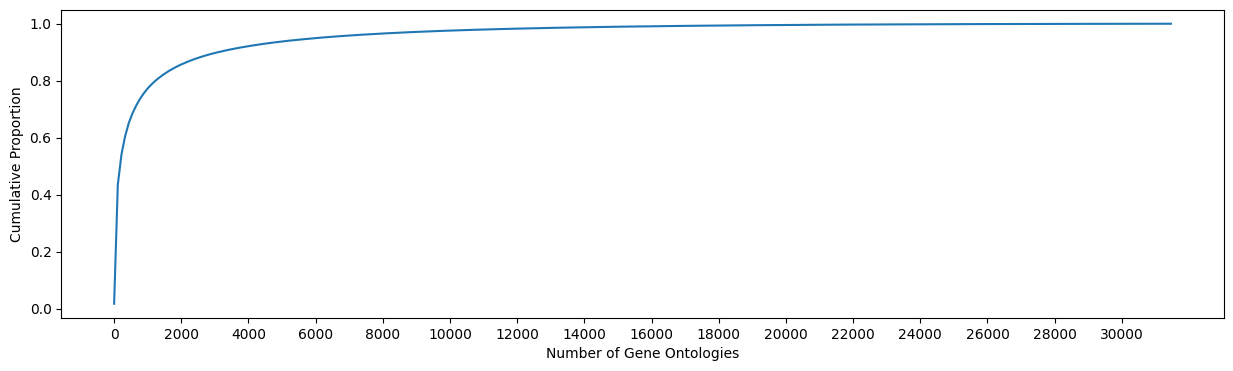

In [241]:
#
plt.figure(figsize=(15, 4));
plt.plot(x, y);
plt.xticks(list(range(0, 31466, 2000)));
plt.xlabel('Number of Gene Ontologies');
plt.ylabel('Cumulative Proportion');

In [183]:
train_terms.term.value_counts(normalize=True)[:2000].sum()

0.8570979534712203

In [154]:
train_terms.term.value_counts(normalize=True)[:6000].sum()

0.9495477419911732

# Exploration

#### Current dataframes:
#### train_proteins
Contains: protein ID, protein description, protein sequence, taxonomy ID, protein sequence length, go term counts per protein,  & counts of unique amino acids

#### go_connections
Contains: go terms, is_a relationships, and aspect

#### train_terms
Contains: protein ID, go term, and aspect

### Questions:
- What are the most common GOs?
- How common are each gene subonotology?
- How many GOs does each protein generally have?
- What is the breakdown of subontologys for each protein?
- How many unique amino acids do protein sequences usually have?

In [216]:
common_go = train_terms.term.value_counts().head(20);
common_go_terms = common_go.index

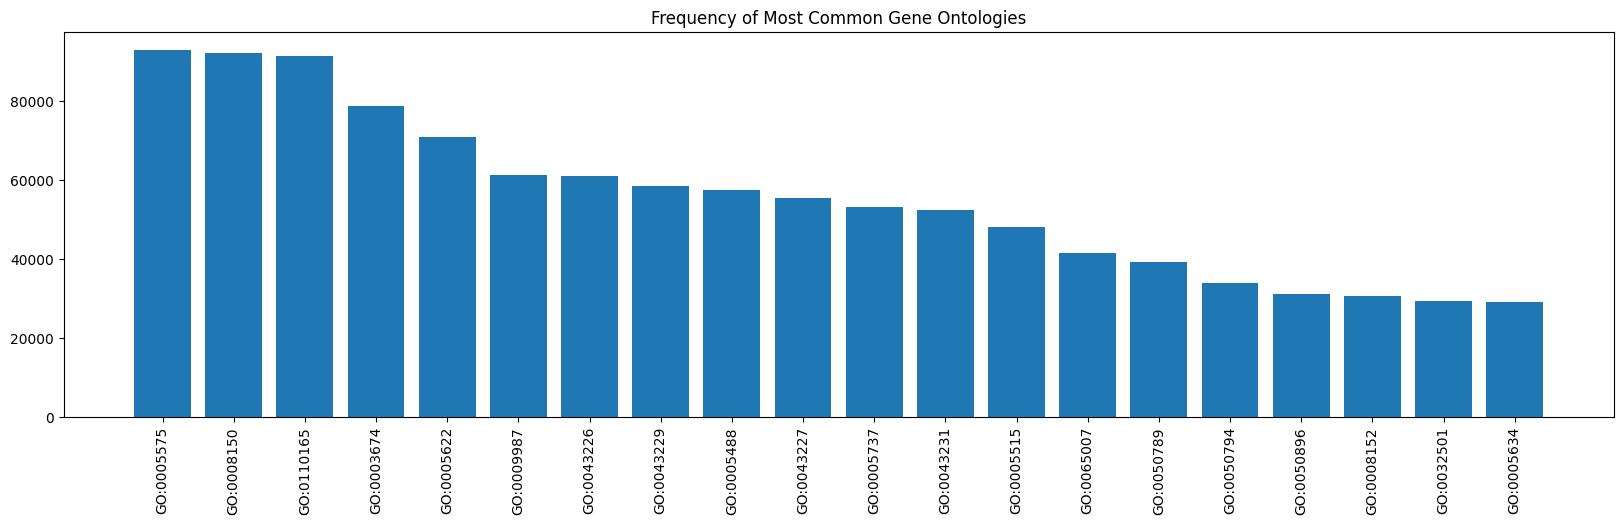

In [224]:
#barchart of top 20 most common gene ontologies
plt.figure(figsize=[20,5]);
plt.bar(x=common_go_terms, height=common_go.values);
plt.xticks(rotation=90);
plt.title('Frequency of Most Common Gene Ontologies');

The most common gene ontologies are :
> 'GO:0005575', 'GO:0008150', 'GO:0110165', 'GO:0003674', 'GO:0005622',
       'GO:0009987', 'GO:0043226', 'GO:0043229', 'GO:0005488', 'GO:0043227
       'GO:0005737', 'GO:0043231', 'GO:0005515', 'GO:0065007', 'GO:0050789',
       'GO:0050794', 'GO:0050896', 'GO:0008152', 'GO:0032501', 'GO:0005634'

They are all present in ~30000+ proteins.

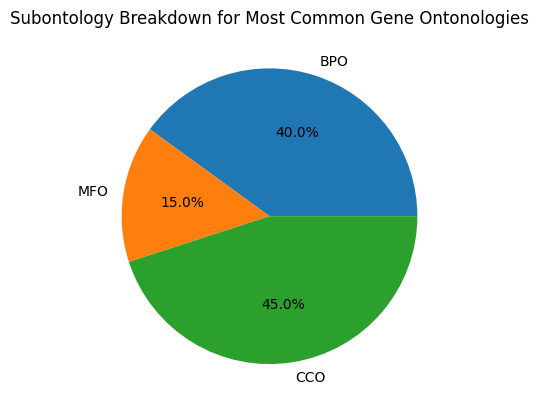

In [479]:
#pie chart of subontologies for most common gene ontologies
data=go_connections[go_connections.term.isin(common_go_terms)].aspect.value_counts(normalize=True).reindex(['BPO', 'MFO', 'CCO'])
plt.pie(data, autopct='%1.1f%%', labels=data.index);
plt.title('Subontology Breakdown for Most Common Gene Ontonologies');

For the most common gene ontologies, 45% (9) of them have CCO as a subontology and 40% (8) have BPO.
This doesn't mean much when we're only looking at 20 gene ontologies.

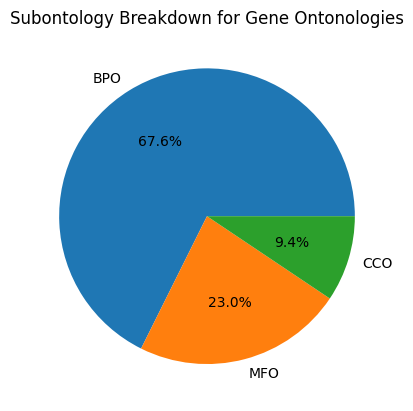

In [355]:
#pie chart of subontologies for all gene ontologies
data = go_connections.aspect.value_counts(normalize=True)
plt.pie(data, autopct='%1.1f%%', labels=data.index); 
plt.title('Subontology Breakdown for Gene Ontonologies');

The most common subontology is BPO. It accounts for 2/3 of the gene ontologies. What's strange is that CCO, which accounts of 9% of the gene ontologies is more common amoung GOs that have high frequencies.

In [223]:
high_go_proteins = train_terms.EntryID.value_counts().head(20);
high_go_proteins_IDs = high_go_proteins.index;

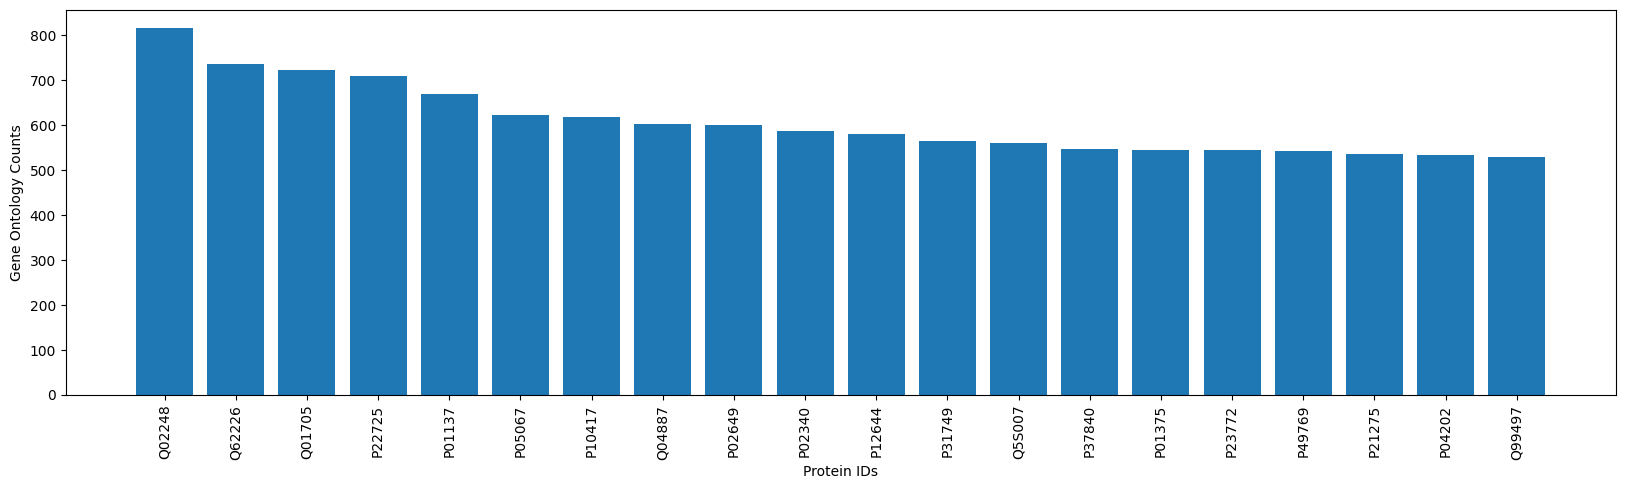

In [225]:
#barchart of proteins with high gene ontology counts
plt.figure(figsize=[20,5]);
plt.bar(x=high_go_proteins_IDs, height=high_go_proteins.values);
plt.xticks(rotation=90);
plt.xlabel('Protein IDs');
plt.ylabel('Gene Ontology Counts');

Proteins that have a high amounts of gene ontologies associated with them are:
> 'Q02248', 'Q62226', 'Q01705', 'P22725', 'P01137', 'P05067', 'P10417',
       'Q04887', 'P02649', 'P02340', 'P12644', 'P31749', 'Q5S007', 'P37840',
       'P01375', 'P23772', 'P49769', 'P21275', 'P04202', 'Q99497'

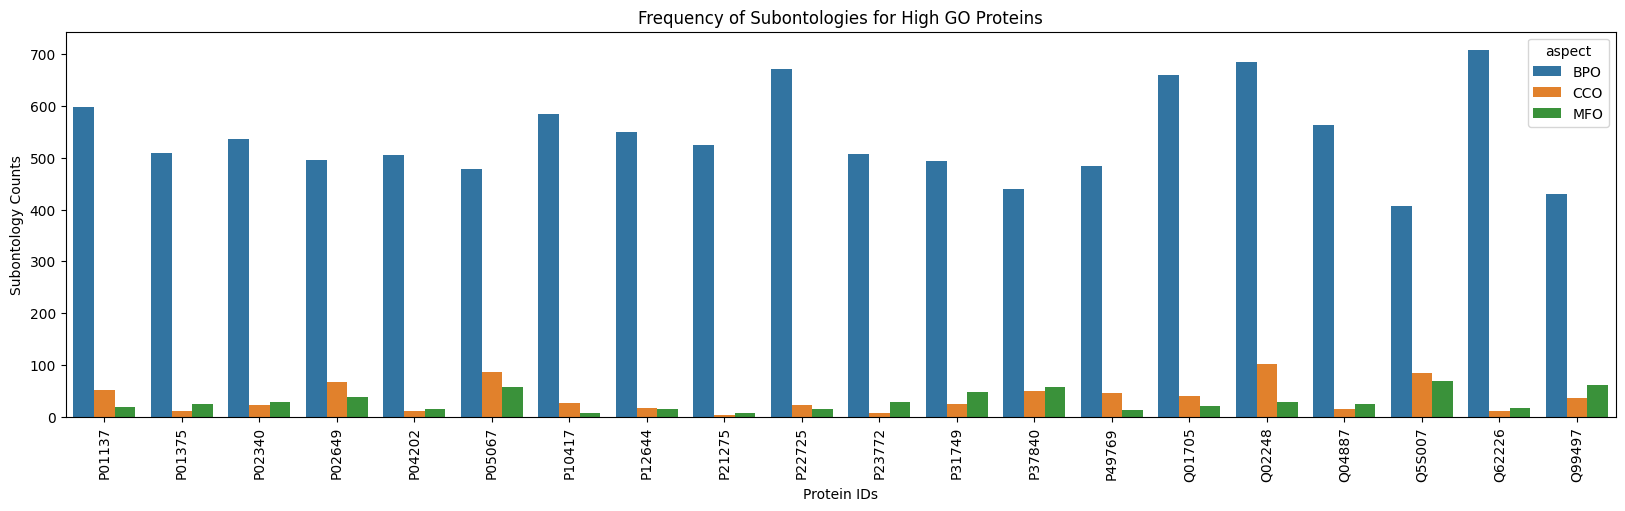

In [482]:
plt.figure(figsize=[20,5]);
sb.countplot(data=train_terms[train_terms.EntryID.isin(high_go_proteins_IDs)], x='EntryID', hue='aspect');
plt.xticks(rotation=90);
plt.xlabel('Protein IDs');
plt.ylabel('Subontology Counts');
plt.title('Frequency of Subontologies for High GO Proteins');

BPO is the most common subontology (by far) for every protein with high counts of gene ontologies.

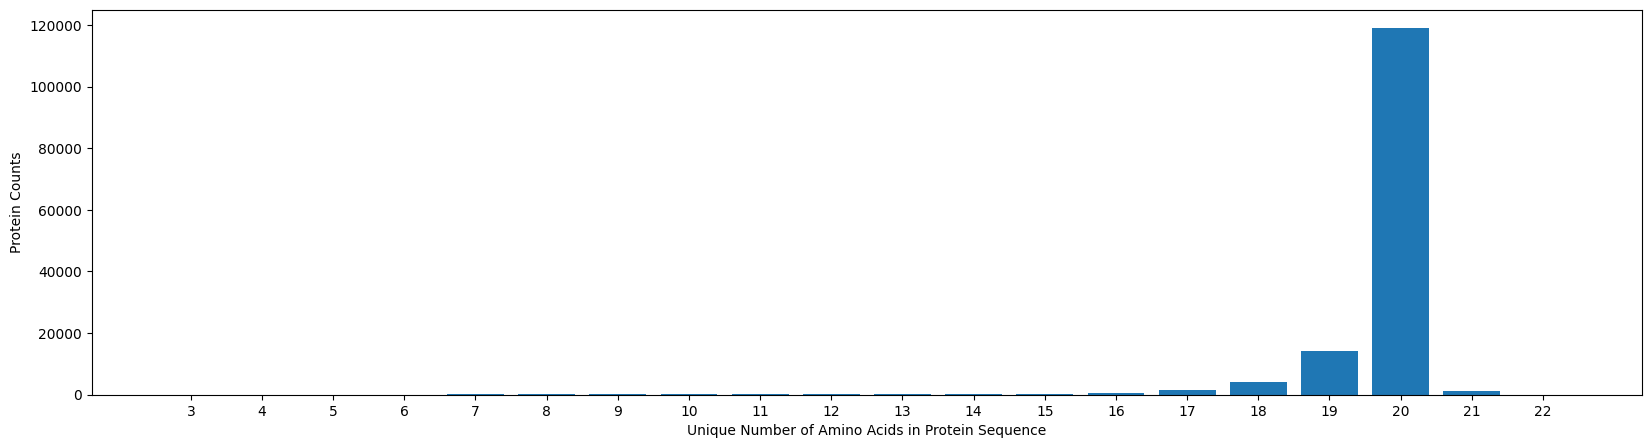

In [483]:
#get frequency of unique amino acids counts
amino_acid_counts = train_proteins.amino_count.value_counts().reindex(range(3,23))

#barchart of amino acid counts for each protein sequence
plt.figure(figsize=[20,5]);
plt.bar(x=amino_acid_counts.index, height=amino_acid_counts.values);
plt.xticks(range(3, 23));
plt.xlabel('Unique Number of Amino Acids in Protein Sequence');
plt.ylabel('Protein Counts');

With how many protein sequences have all 20 amino acids, it might be worth segmenting the data to look at proteins with 20 and proteins without 20 amino acids present in the sequence.

### More Questions:
- Is there any relationship between number of amino acids in a protein sequence, length of a protein sequences, and number of gene ontologies associated with a protein?
- Is there a relationship between the presence of cerain amino acids in a protein & a GO?
- Are there amino acids groupings in a protein sequence that relate to certain GOs?

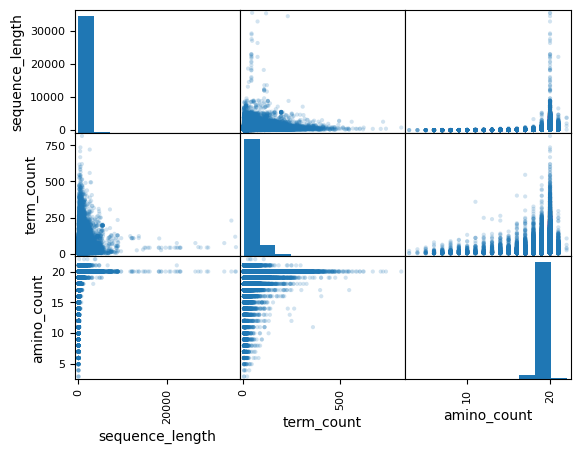

In [21]:
#investigating general groupings of sequence length, term count & amino acide count in proteins
pd.plotting.scatter_matrix(train_proteins[['sequence_length', 'term_count', 'amino_count']], alpha=0.2);

Sequence Length vs Term Count:

Amino Count vs Term Count:

Sequence Length vs Amino Count:



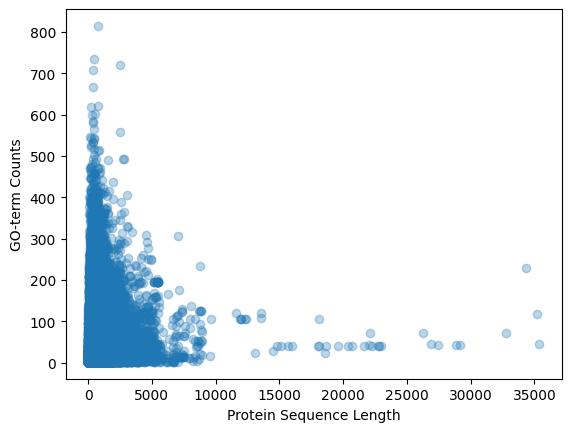

In [443]:
plt.scatter(data=train_proteins, x='sequence_length', y='term_count', alpha=0.3);
plt.xlabel('Protein Sequence Length');
plt.ylabel('GO-term Counts');

Observations:
- There are not many proteins with sequences longer than 10000 in length. However, those that exist, typically have 150 or less GO-terms.
- Proteins with high counts of GO-terms (greater than 200), typically have sequences less than 5000 in length.

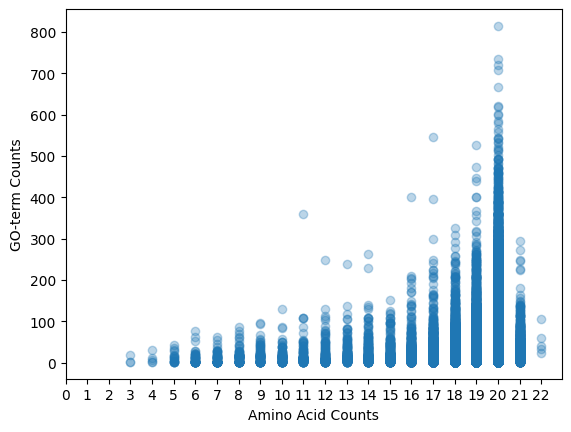

In [453]:
import numpy as np
plt.scatter(data=train_proteins, x='amino_count', y='term_count', alpha=0.3);
plt.xticks(np.arange(23));
plt.xlabel('Amino Acid Counts');
plt.ylabel('GO-term Counts');

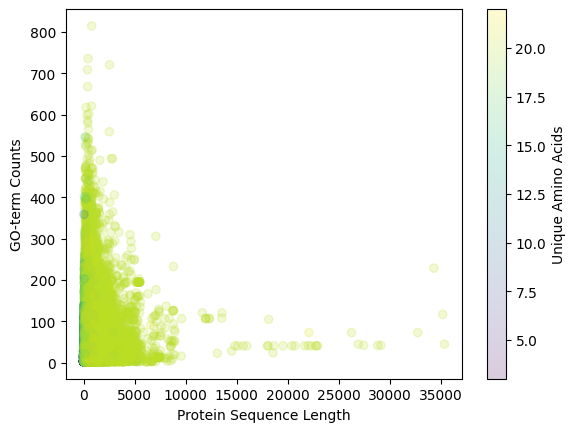

In [462]:
plt.scatter(data=train_proteins, x='sequence_length', y='term_count', c='amino_count', alpha=0.2);
plt.colorbar(label='Unique Amino Acids');
plt.xlabel('Protein Sequence Length');
plt.ylabel('GO-term Counts');

There doesn't seem to be a relationship between unique number of amino acids and go-terms counts/protein sequence length.

,EntryID,description,sequence,taxonomyID,sequence_length,term_count,amino_count
0,P20536,P20536 sp|P20536|UNG_VACCC Uracil-DNA glycosyl...,"(M, N, S, V, T, V, S, H, A, P, Y, T, I, T, Y, ...",10249,218,33,20
1,O73864,O73864 sp|O73864|WNT11_DANRE Protein Wnt-11 OS...,"(M, T, E, Y, R, N, F, L, L, L, F, I, T, S, L, ...",7955,354,170,20
2,O95231,O95231 sp|O95231|VENTX_HUMAN Homeobox protein ...,"(M, R, L, S, S, S, P, P, R, G, P, Q, Q, L, S, ...",9606,258,62,20
3,A0A0B4J1F4,A0A0B4J1F4 sp|A0A0B4J1F4|ARRD4_MOUSE Arrestin ...,"(M, G, G, E, A, G, A, D, G, P, R, G, R, V, K, ...",10090,415,45,20
4,P54366,P54366 sp|P54366|GSC_DROME Homeobox protein go...,"(M, V, E, T, N, S, P, P, A, G, Y, T, L, K, R, ...",7227,415,20,20
...,...,...,...,...,...,...,...
142241,A0A286YAI0,A0A286YAI0 tr|A0A286YAI0|A0A286YAI0_DANRE Macr...,"(M, E, T, E, V, D, D, F, P, G, K, A, S, I, F, ...",7955,450,17,20
142242,A0A1D5NUC4,A0A1D5NUC4 tr|A0A1D5NUC4|A0A1D5NUC4_CHICK Mito...,"(M, S, A, A, A, S, A, E, M, I, E, T, P, P, V, ...",9031,643,26,20
142243,Q5RGB0,Q5RGB0 tr|Q5RGB0|Q5RGB0_DANRE Potassium channe...,"(M, A, D, K, G, P, I, L, T, S, V, I, I, F, Y, ...",7955,448,35,20
142244,A0A2R8QMZ5,A0A2R8QMZ5 tr|A0A2R8QMZ5|A0A2R8QMZ5_DANRE Myoc...,"(M, G, R, K, K, I, Q, I, T, R, I, M, D, E, R, ...",7955,459,91,20
